In [ ]:
#install necessary libraries and dependencies
!pip install tensorflow opencv-python matplotlib

In [ ]:
import tensorflow as tf 
import os #operating system interaction

In [ ]:
import cv2 #for realtime computer vision
import imghdr #to determine the image type

In [ ]:
#preprocessing 
#load data
#remove dodgy images

train_data_dir = 'data/train' #train data directory
test_data_dir = 'data/test' #test data directory

image_exts = ['jpeg','jpg', 'bmp', 'png'] #valid image extensions

In [ ]:
#function to iterate through all images and remove ones with invalid extensions
def img_ext(data_dir):
    for image_class in os.listdir(data_dir):
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            
img_ext(train_data_dir)
img_ext(test_data_dir)

In [ ]:
tf.keras.utils.set_random_seed(12) #random seeding for consistency

batch_size = 32
#desired image dimensions
img_height = img_weight = 256

In [ ]:
#data visualization
#import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
train_data = tf.keras.utils.image_dataset_from_directory('data/train') #load data from train drectory

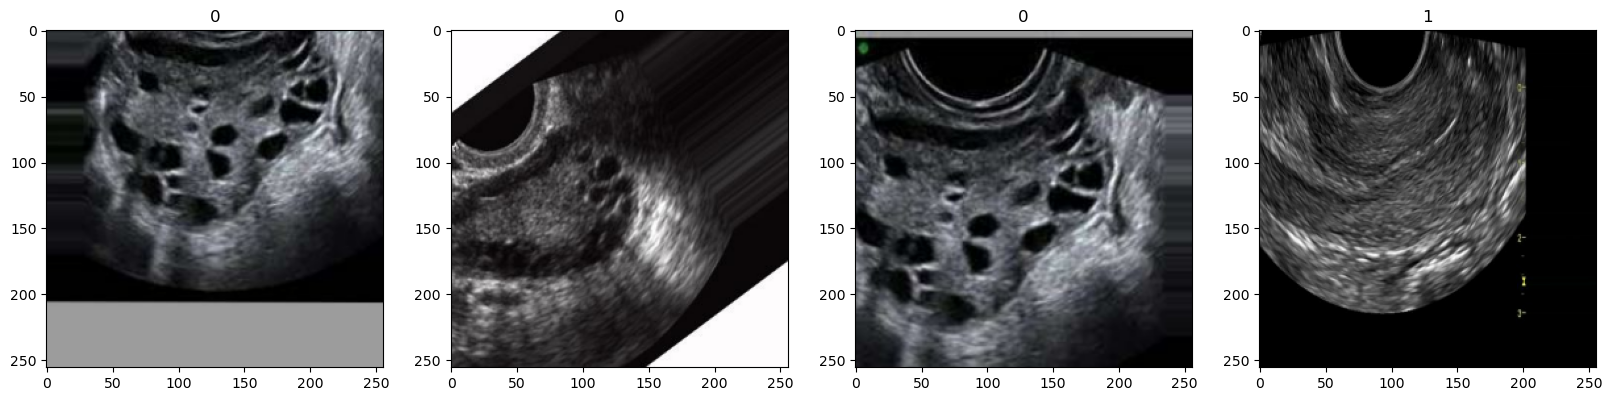

In [43]:
train_data_iterator = train_data.as_numpy_iterator() #to iterate through the dataset
batch = train_data_iterator.next() #display the data in batch
#display image and their classes
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
    #from our visuualized images, we can see that label 0 indicates infected and 1 indicates not infected

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#data augmention and generators for training and validation
train_datagen = ImageDataGenerator(rescale = 1.0/255.0, #rescale pixel values to range 0 to 1
                                   shear_range = 0.2,  #apply shearing transformation to images
                                   zoom_range = 0.2, #apply random zoom to images up to 20%
                                  # width_shift_range=0.2, #randomly shift the width of images up to 20%
                                   #height_shift_range=0.2, #randomly shift the heigth of images up to 20%
                                   horizontal_flip = True, #horizontally flip images randomly
                                   vertical_flip=True, #vertically flip images randomly
                                   rotation_range=20, #randomly rotate images by up to 20 degrees
                                   validation_split=0.2, #split data into training and validation using 80:20 ratio
                                   fill_mode='nearest' #fill newly created pixels with the nearest pixel value
                                  )
#generator for training data
train_gen = train_datagen.flow_from_directory(train_data_dir,
                                              class_mode='categorical', #label encoding type for one-hot encoding
                                              classes=['infected', 'notinfected'], #prediction classes expected
                                              target_size=(img_height, img_weight), #resize image to specified dimensions
                                              batch_size=batch_size, #number of images per batch
                                              subset='training', #subset of data (in this case training)
                                              seed=12 #seeding for consistency
                                             )
#genarator for validation data
validation_gen = train_datagen.flow_from_directory(train_data_dir,
                                              class_mode='categorical', #label encoding type for one-hot encoding
                                              classes=['infected', 'notinfected'], #prediction classes expected
                                              target_size=(img_height, img_weight), #resize image to specified dimensions
                                              batch_size=batch_size, #number of images per batch
                                              subset='validation', #subset of data (in this case validation)
                                              seed=12 #seeding for consistency
                                             )

Found 1540 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [52]:
test_dat = train_datagen.flow_from_directory(
    test_data_dir,
    seed=12,
    target_size=(img_height, img_weight),
    batch_size=batch_size
)

Found 1922 images belonging to 2 classes.


In [60]:
#build model
#import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

#convolutional layer with 16 filters, each of size of 3by3 pixels, stride of 1 and ReLU activation
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))

#max pooling layer scans through the values return after ReLU activation, condenses and returns the max value
model.add(MaxPooling2D(2, 2))

#convolutional layer with 32 filters
model.add(Conv2D(64, (3,3), 1, activation='relu'))

#max pooling layer
model.add(MaxPooling2D(2, 2))

#convolutional layer with 16 filters
model.add(Conv2D(128, (3,3), 1, activation='relu'))

#max pooling layer
model.add(MaxPooling2D(2, 2))

#flatten layer to flatten down the channel values to a single value
model.add(Flatten())

#fully connected layers with 256 neurons and ReLU activation
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))

#last layer is a single dense layer with sigmoid activation to represent our expected output of 0 or 1
#0 represents infected and 1 represent notinfected
model.add(Dense(1, activation='softmax'))

In [65]:
model = Sequential()

model.add(Conv2D(12, (5,5),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.1))

model.add(Conv2D(8, (5,5),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.1))

model.add(Conv2D(4, (5,5),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(2,activation='softmax'))

opt=Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
#import optimizer
from tensorflow.keras.optimizers import Adam

#opt=Adam() #optimizer for model compilation with learning rate of 0.01
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
earlyStopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1,patience=15)

In [67]:
history = model.fit(
    train_gen,
    validation_data=validation_gen,
    callbacks=[earlyStopping],
    batch_size=batch_size,
    verbose=1,
    epochs=20)

Epoch 1/20
49/49 [==============================] - 121s 2s/step - loss: 0.4965 - accuracy: 0.7578 - val_loss: 0.2115 - val_accuracy: 0.9115
Epoch 2/20
49/49 [==============================] - 117s 2s/step - loss: 0.3034 - accuracy: 0.8818 - val_loss: 0.2639 - val_accuracy: 0.8828
Epoch 3/20
49/49 [==============================] - 118s 2s/step - loss: 0.1175 - accuracy: 0.9623 - val_loss: 0.0311 - val_accuracy: 0.9870
Epoch 4/20
49/49 [==============================] - 85s 2s/step - loss: 0.0367 - accuracy: 0.9890 - val_loss: 0.0111 - val_accuracy: 0.9896
Epoch 5/20
49/49 [==============================] - 50s 1s/step - loss: 0.1354 - accuracy: 0.9721 - val_loss: 0.0812 - val_accuracy: 0.9661
Epoch 6/20
49/49 [==============================] - 50s 1s/step - loss: 0.0322 - accuracy: 0.9916 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 7/20
49/49 [==============================] - 52s 1s/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 8/20
49/49 